## Sentinel Hub / Xcube Integration Demo 2

This demo is very similar to [demo-sh.ipynb](./demo-sh.ipynb) which is slightly modified:

* We will create an **temporarily irregular cube**, which only includes time stamps where there were valid observations for a given region;
* New variables will be generated using xcube's `compute_cube` function that will **utilize a compute cluster**.

In addition to the [demo-sh.ipynb](./demo-sh.ipynb)'s setup, we need to define an additional environment variable `SH_INSTANCE_ID`. This is required by the [SentinelHub WFS request](https://sentinel-hub.com/develop/documentation/api/ogc_api/wfs-request) which is used to determine time stamps with valid observations for the given region:

```bash
(xcube) $ export SH_INSTANCE_ID=<your-instance-id>
```




In [1]:
import json

import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [11]:
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.geodb import GeoDB
from xcube_sh.viewer import ViewerServer

from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

In [12]:
%matplotlib inline

---
For this demo, we are focussing on small coastal area near Kiel, Narth Germany (Baltic Sea)

In [13]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

In [14]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is 20 meters per pixel

In [15]:
spatial_res = 0.00018   # = 20.038 meters in degree

In [16]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         chunk_size=[512, 512],
                         geometry=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_tolerance='30M')

In [17]:
# So we can print some SentinelHub usage stats
request_collector = Observers.request_collector()

In [18]:
cube = open_cube(cube_config, request_collector)
cube

ValueError: instance_id must be provided. Consider setting environment variable SH_INSTANCE_ID.

In [ ]:
cube

In [11]:
cube.time

<xarray.DataArray 'time' (time: 46)>
array(['2018-05-15T10:30:24.000000000', '2018-05-17T10:22:09.000000000',
       '2018-05-18T10:40:24.000000000', '2018-05-20T10:34:58.000000000',
       '2018-05-22T10:20:25.000000000', '2018-05-23T10:41:24.000000000',
       '2018-05-25T10:30:24.000000000', '2018-05-28T10:40:23.000000000',
       '2018-05-30T10:30:18.000000000', '2018-06-01T10:20:24.000000000',
       '2018-06-02T10:41:02.000000000', '2018-06-04T10:30:22.000000000',
       '2018-06-06T10:25:12.000000000', '2018-06-07T10:40:22.000000000',
       '2018-06-09T10:32:14.000000000', '2018-06-11T10:20:22.000000000',
       '2018-06-12T10:43:56.000000000', '2018-06-14T10:30:21.000000000',
       '2018-06-16T10:20:21.000000000', '2018-06-17T10:43:21.000000000',
       '2018-06-19T10:30:20.000000000', '2018-06-21T10:23:16.000000000',
       '2018-06-22T10:40:21.000000000', '2018-06-24T10:35:03.000000000',
       '2018-06-26T10:20:22.000000000', '2018-06-27T10:40:23.000000000',
       '2018-0

In [12]:
cube.B04

<xarray.DataArray 'B04' (time: 46, lat: 2048, lon: 5632)>
dask.array<zarr, shape=(46, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Attributes:
    sample_type:  FLOAT32
    units:        reflectance
    wavelength:   664.6
    bandwith:     31
    resolution:   10

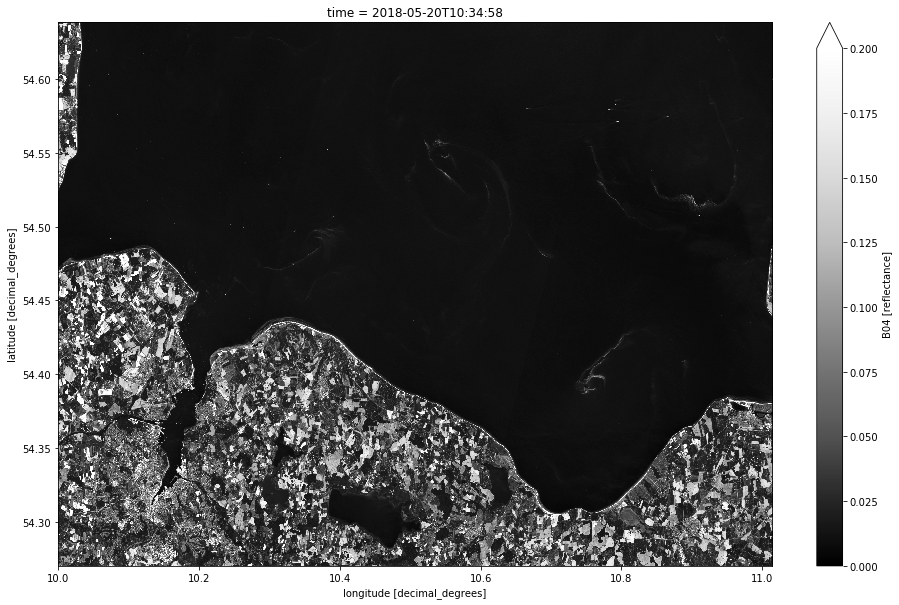

In [13]:
cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [14]:
request_collector.stats

Scene classification flags have CF-conformant flag encoding information, which xcube can decode

In [15]:
cube.SCL

<xarray.DataArray 'SCL' (time: 46, lat: 2048, lon: 5632)>
dask.array<zarr, shape=(46, 2048, 5632), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Attributes:
    sample_type:    UINT8
    flag_values:    0,1,2,3,4,5,6,7,8,9,10,11
    flag_meanings:  no_data saturated_or_defective dark_area_pixels cloud_sha...

In [16]:
scene_classif = MaskSet(cube.SCL)
scene_classif

xcube mask sets also follow data cube structure

In [17]:
scene_classif.water

<xarray.DataArray 'water' (time: 46, lat: 2048, lon: 5632)>
dask.array<where, shape=(46, 2048, 5632), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24

D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429: Too Many Requests. Attempt 1 of 5 to retry after 35.00 + 88.23 = 123.23 ms...
  warnings.warn(retry_message)
D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429: Too Many Requests. Attempt 1 of 5 to retry after 13.00 + 78.72 = 91.72 ms...
  warnings.warn(retry_message)
D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429: Too Many Requests. Attempt 2 of 5 to retry after 12.00 + 161.70 = 173.70 ms...
  warnings.warn(retry_message)
D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429: Too Many Requests. Attempt 1 of 5 to retry after 58.00 + 21.77 = 79.77 ms...
  warnings.warn(retry_message)
D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429: Too Many Requests. Attempt 2 of 5 to retry after 30.00 + 179.83 = 209.83 ms...
  warnings.warn(retry_message)
D:\Projects\xcube-dcfs\xcube_sh\sentinelhub.py:182: UserWarning: Error 429:

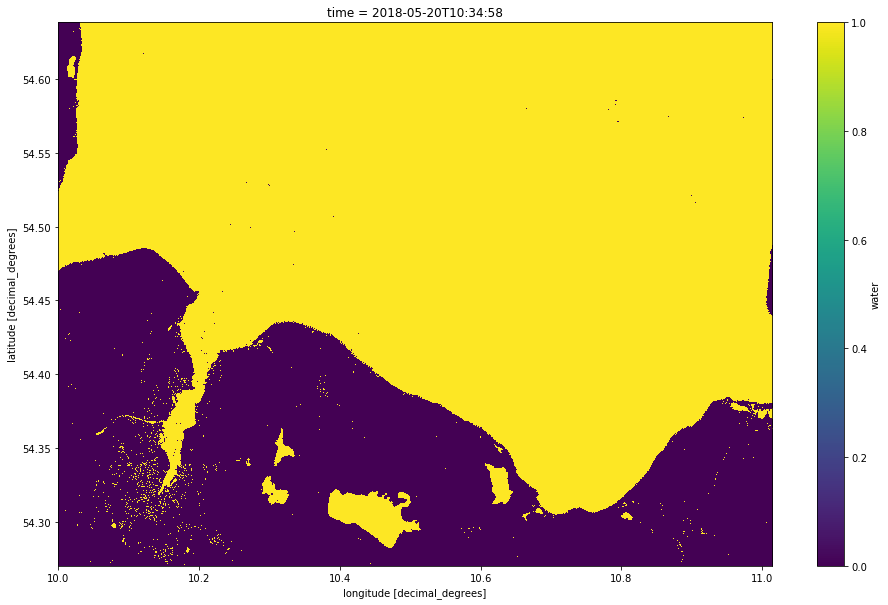

In [18]:
scene_classif.water.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(figsize=(16, 10))

In [19]:
request_collector.stats

We can use any of the mask or combinations of it to mask entire cubes. Here we create a "water cube":

In [20]:
water_cube = cube.where(scene_classif.water)
water_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 46)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(46, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 5

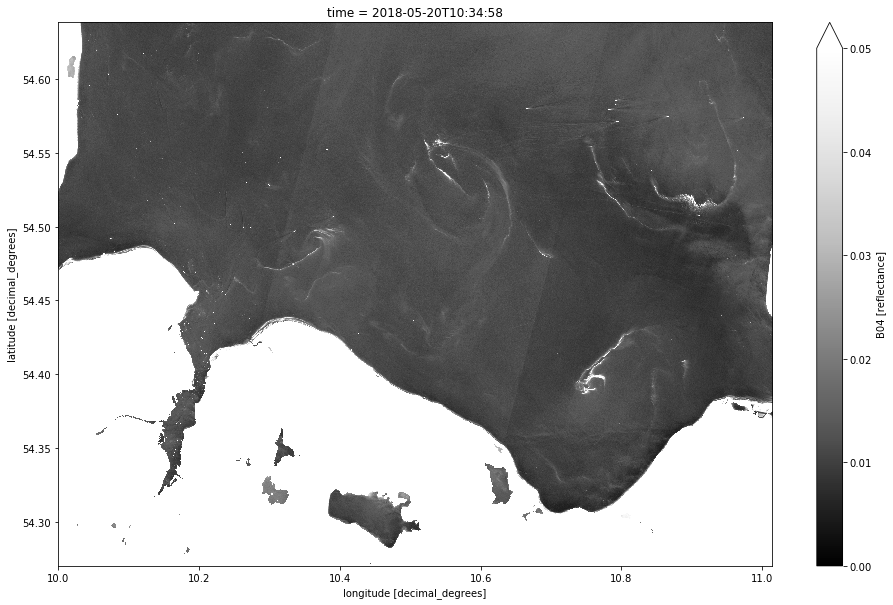

In [21]:
water_cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.05, cmap='Greys_r', figsize=(16, 10))

In [22]:
request_collector.stats

---

We now compute a Chlorophyll indicator called *Maximum Chlorophyll Index* from bands B04, B05, B06:

In [23]:
b_from = water_cube.B04
b_peek = water_cube.B05
b_to = water_cube.B06

wlen_from = b_from.attrs['wavelength']
wlen_peek = b_peek.attrs['wavelength']
wlen_to = b_to.attrs['wavelength']

f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
mci = (b_peek - b_from) - f * (b_to - b_from)

mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
mci.attrs['units'] = 'unitless'
mci

<xarray.DataArray (time: 46, lat: 2048, lon: 5632)>
dask.array<sub, shape=(46, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

---

And the well-known *Normalised Difference Vegetation Index*:

In [24]:
veg_cube = cube.where(scene_classif.vegetation)
veg_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2048, lon: 5632, time: 46)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(46, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 5

In [25]:
b_red = veg_cube.B04
b_nir = veg_cube.B11
ndvi = (b_nir - b_red) / (b_nir + b_red)
ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'
ndvi

<xarray.DataArray (time: 46, lat: 2048, lon: 5632)>
dask.array<truediv, shape=(46, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Attributes:
    long_name:  Normalized Difference Vegetation Index
    units:      unitless

In [26]:
my_cube = xr.Dataset({'mci': mci, 'ndvi': ndvi})
my_cube

<xarray.Dataset>
Dimensions:  (lat: 2048, lon: 5632, time: 46)
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Data variables:
    mci      (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ndvi     (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

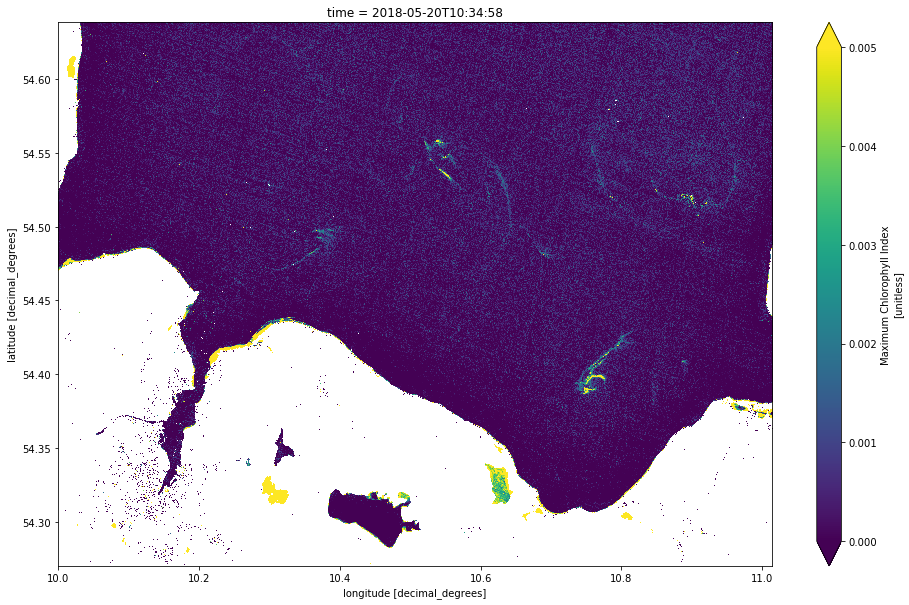

In [27]:
my_cube.mci.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.005, cmap='viridis', figsize=(16, 10))

In [28]:
request_collector.stats

---

Now we are going for a spatial subset within the scene, the lake *Selenter See*: 

In [29]:
geodb = GeoDB()

aoi = geodb.find_feature('S_NAME == "Selenter_See"')

IPython.display.GeoJSON(aoi)

<IPython.display.GeoJSON object>

We are clipping the cube to the polygon and masking "mci" but exclude "ndvi":

In [30]:
my_masked_cube = mask_dataset_by_geometry(my_cube, aoi, no_clip=False, save_geometry_wkt=True, excluded_vars='ndvi')
my_masked_cube

<xarray.Dataset>
Dimensions:  (lat: 230, lon: 739, time: 46)
Coordinates:
  * lat      (lat) float64 54.32 54.32 54.32 54.32 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.38 10.38 10.38 10.38 ... 10.51 10.51 10.51 10.52
  * time     (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-31T10:20:24
Data variables:
    mci      (time, lat, lon) float32 dask.array<chunksize=(1, 230, 437), meta=np.ndarray>
    ndvi     (time, lat, lon) float32 dask.array<chunksize=(1, 230, 437), meta=np.ndarray>
Attributes:
    geospatial_lon_min:         10.38214
    geospatial_lon_max:         10.51516
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0001799999999999998
    geospatial_lat_min:         54.2817
    geospatial_lat_max:         54.323100000000004
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00018000000000001177
    date_modified:              2019-10-30T14:53:57.259793
    geometry_wkt:               POLYGON Z ((10.

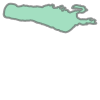

In [31]:
import shapely.wkt
shapely.wkt.loads(my_masked_cube.attrs['geometry_wkt'])

In [32]:
filename = 'my_masked_cube.zarr'
#import shutil
#shutil.rmtree(filename, ignore_errors=True)
#my_masked_cube = my_masked_cube.chunk(chunks=dict(time=1, lat=230, lon=739))
#my_masked_cube.to_zarr(filename)

In [33]:
my_masked_cube = xr.open_zarr(filename)

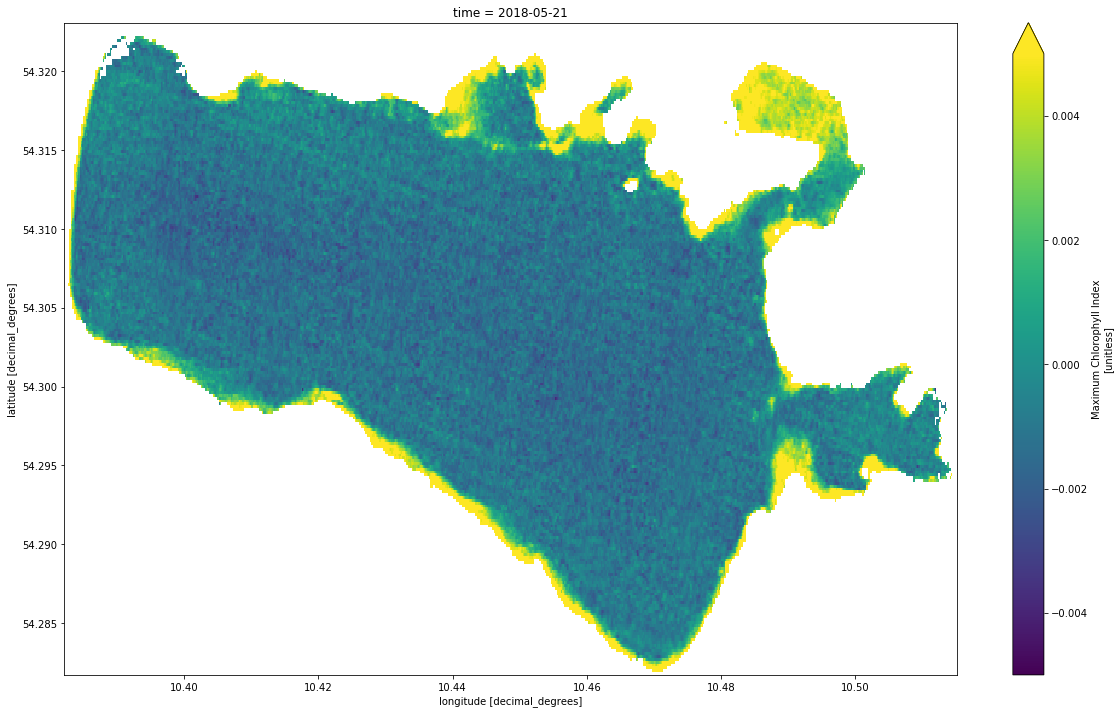

In [34]:
my_masked_cube.mci.sel(time='2018-05-21').plot.imshow(vmin=-0.005, vmax=0.005, cmap='viridis', figsize=(20,12))

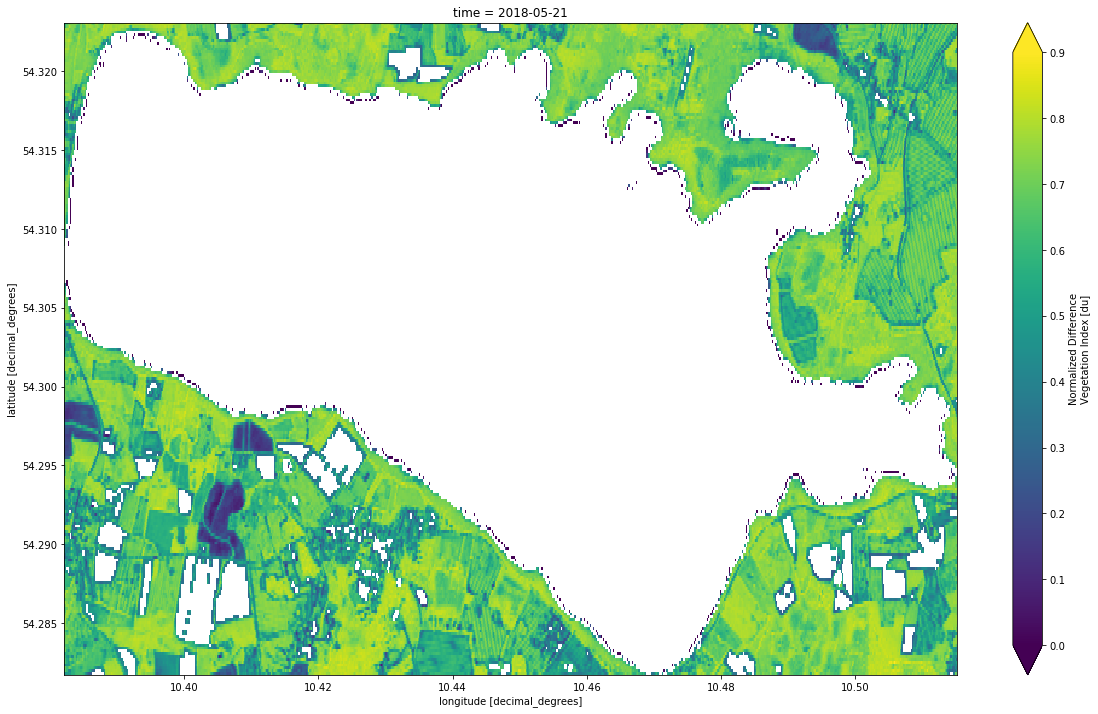

In [35]:
my_masked_cube.ndvi.sel(time='2018-05-21').plot.imshow(vmin=0, vmax=0.9, cmap='viridis', figsize=(20,12))

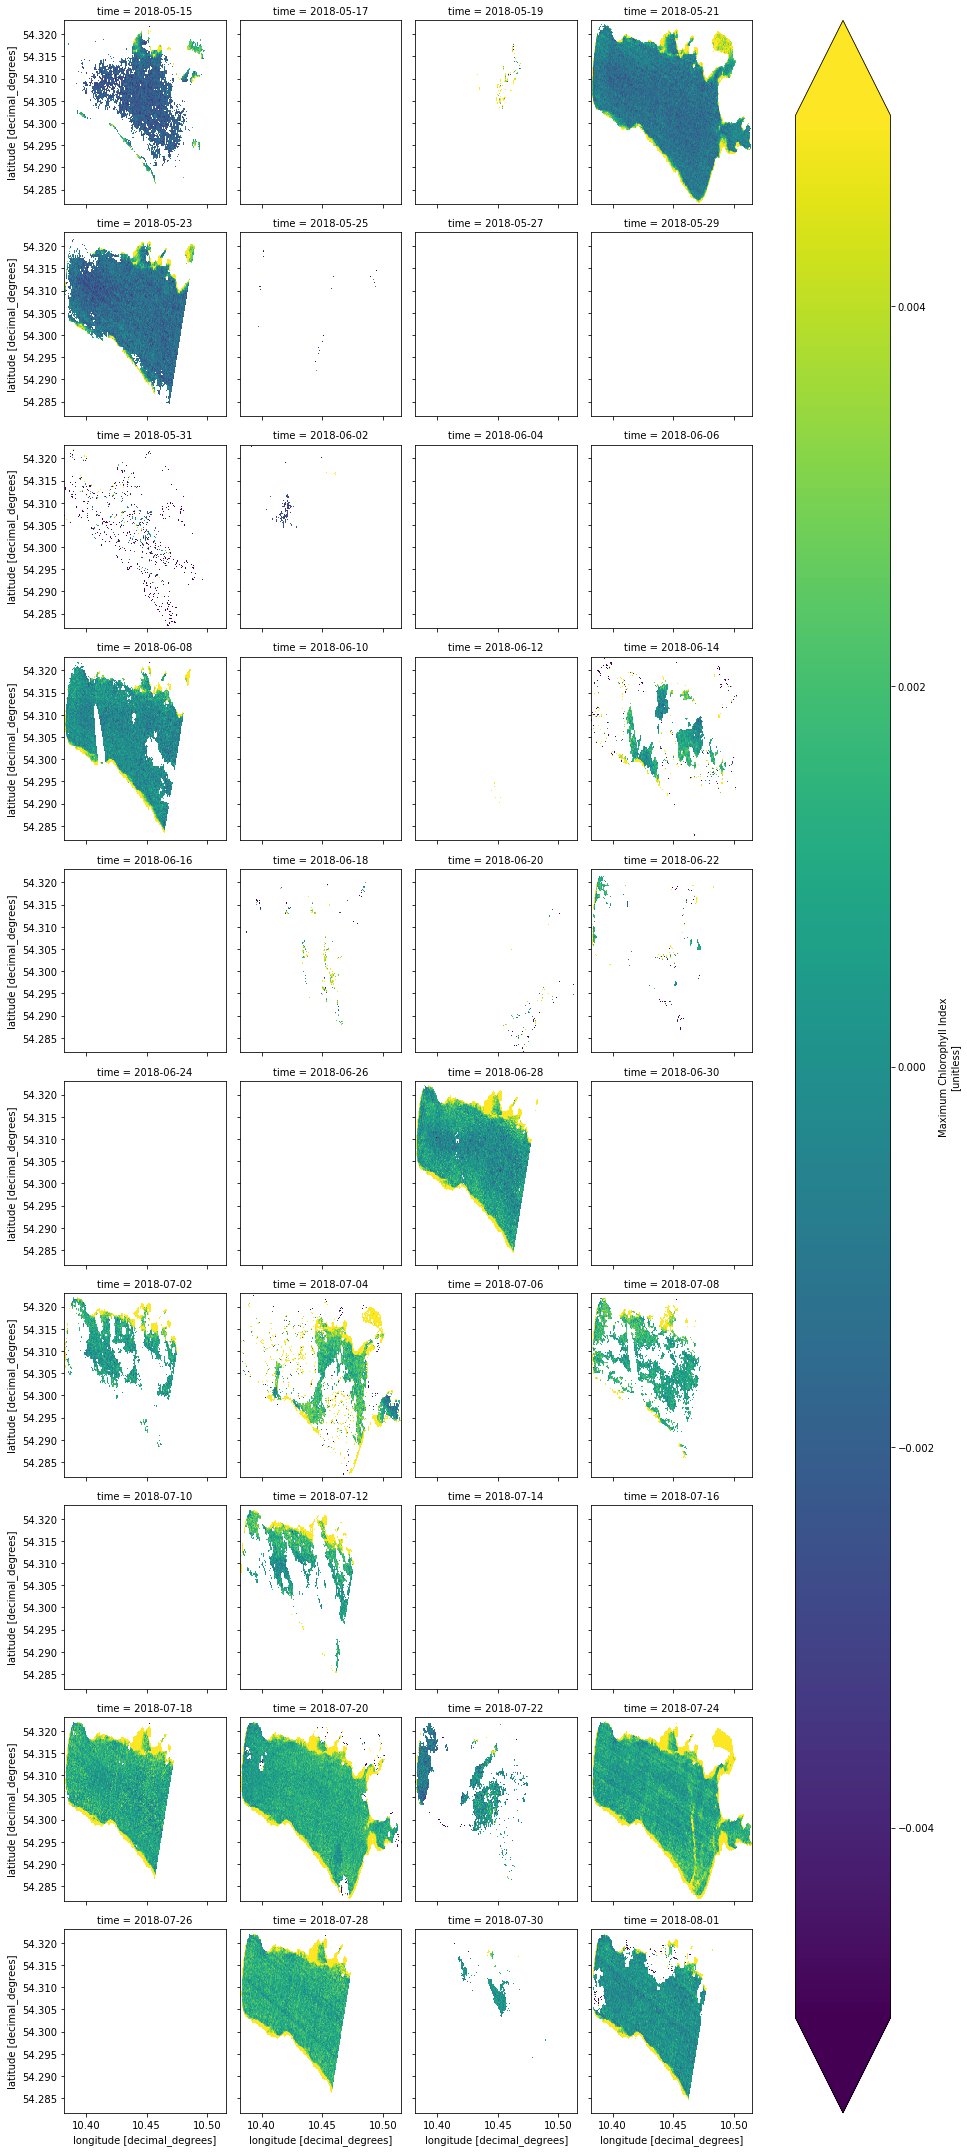

In [36]:
my_masked_cube.mci.plot.imshow(col='time', col_wrap=4, vmin=-0.005, vmax=0.005, cmap='viridis')

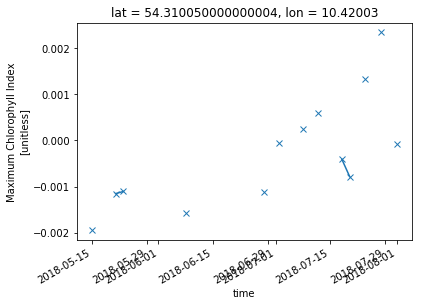

In [37]:
my_masked_cube.mci.sel(lat=54.31, lon=10.42, method='nearest').plot.line(marker='x')

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


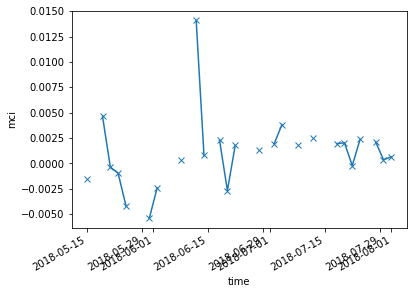

In [38]:
my_masked_cube.mci.mean(dim=('lat', 'lon'), skipna=True).plot.line(marker='x')

In [39]:
mci_mean = my_masked_cube.mci.mean(dim='time')

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


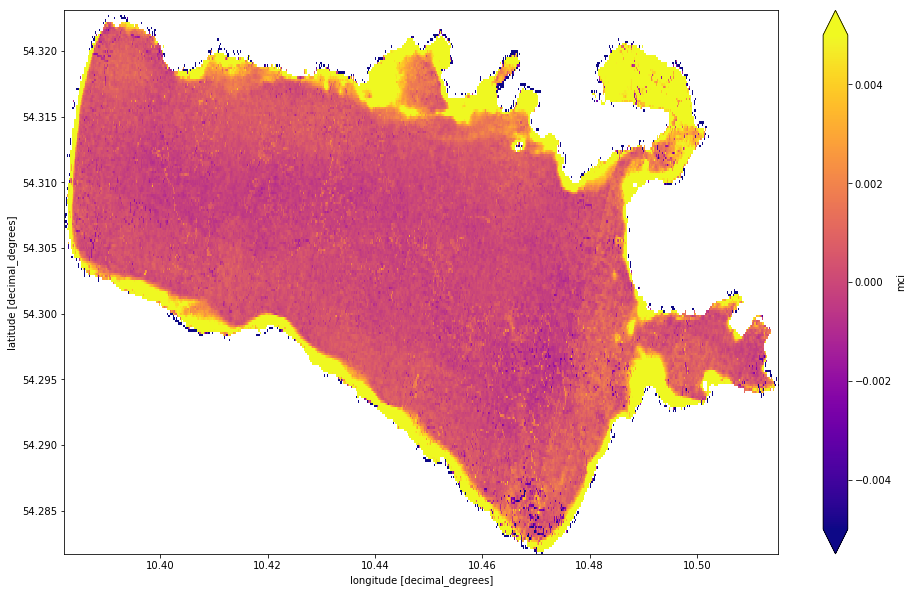

In [40]:
mci_mean.plot.imshow(vmin=-0.005, vmax=0.005, cmap='plasma', figsize=(16,10))

In [41]:
mci_anomaly = my_masked_cube.mci - mci_mean

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packag

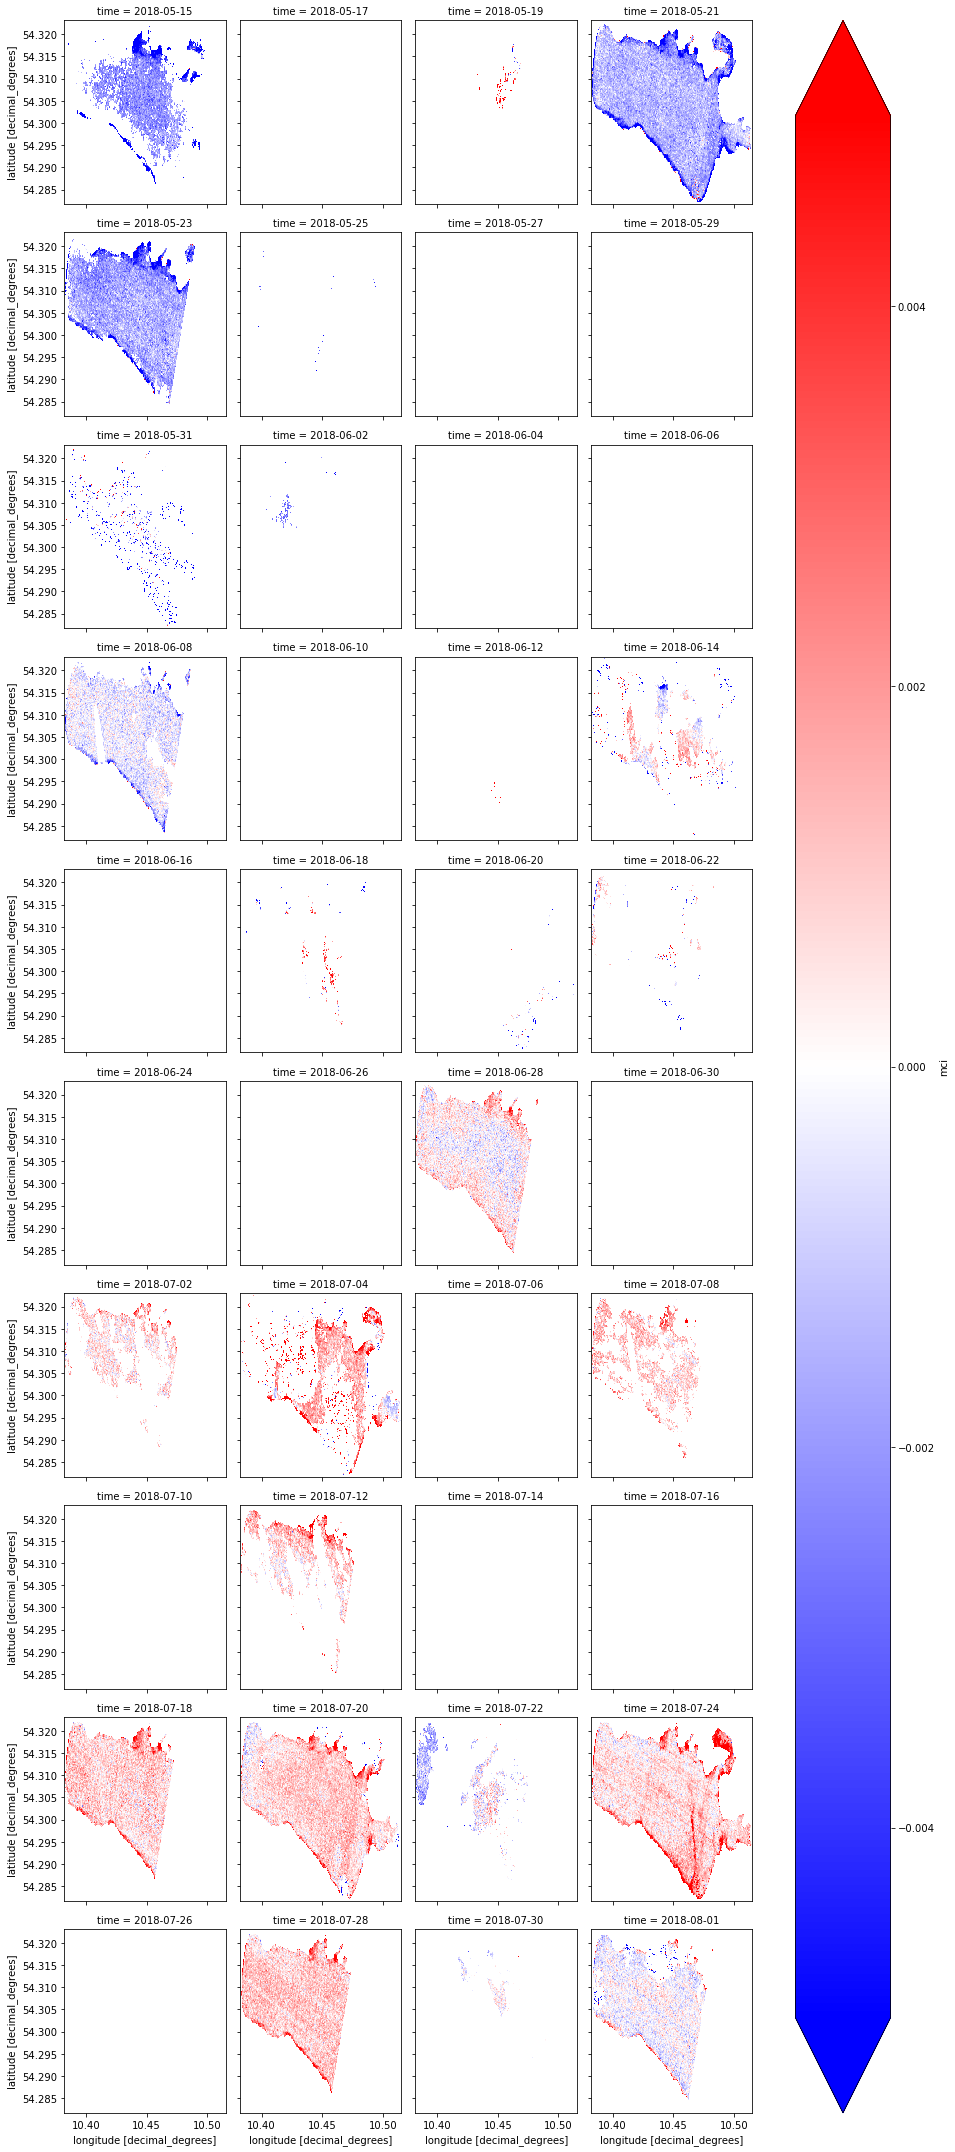

In [42]:
mci_anomaly.plot.imshow(col='time', col_wrap=4, vmin=-0.005, vmax=0.005, cmap='bwr')

---

In [44]:
server = ViewerServer('my_masked_cube.zarr')

running: xcube serve --address 0.0.0.0 my_masked_cube.zarr


In [45]:
server

In [46]:
# server.kill()